In [1]:

import ising_efficient
import network_generation
import sparse_adj_mat
from sparse_adj_mat import Sparse_Adjacency_Matrix
from network_generation import generate_erdos_renyi_sparse_adjacency_matrix
from network_generation import generate_scale_free_sparse_adjacency_matrix_jax
from network_generation import generate_small_world_sparse_adjacency_matrix_jax
from ising_efficient import BeliefNetwork
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

In [2]:
def precompute_neighbors(sparse_adj):
    """
    Convert Sparse_Adjacency_Matrix into a list of NumPy arrays.
    """
    neighbors = []
    for i in range(len(sparse_adj)):
        nbs, _ = sparse_adj.get_neighbors_and_weights(i)
        neighbors.append(np.asarray(nbs, dtype=int))
    return neighbors

def connected_components_precomputed(
    neighbors,
    belief_state: np.ndarray,
    target_belief: int
):
    """
    Fastest connected-component extraction for repeated timesteps.
    """
    N = len(neighbors)
    allowed = (belief_state == target_belief)
    visited = np.zeros(N, dtype=bool)
    components = []

    for seed in np.where(allowed & ~visited)[0]:
        queue = deque([seed])
        visited[seed] = True
        component = [seed]

        while queue:
            u = queue.popleft()
            nbs = neighbors[u]

            valid = allowed[nbs] & ~visited[nbs]
            new_nodes = nbs[valid]

            visited[new_nodes] = True
            queue.extend(new_nodes.tolist())
            component.extend(new_nodes.tolist())

        components.append(component)

    return components

#adapted
def bfs_distances(neighbors_list, source: int, allowed_nodes: set):
    """
    Compute shortest-path distances from a source node
    restricted to an induced subgraph.
    
    Args:
        neighbors_list: List where neighbors_list[i] contains neighbor indices for node i
        source: Source node
        allowed_nodes: Set of allowed nodes in the subgraph
    """
    distances = {source: 0}
    queue = deque([source])

    while queue:
        u = queue.popleft()
        neighbors = neighbors_list[u]

        for v in neighbors:
            if v in allowed_nodes and v not in distances:
                distances[v] = distances[u] + 1
                queue.append(v)

    return distances

def component_diameter(neighbors_list,
    component:list, 
):
    """
    Compute the exact diameter of a connected component
    using BFS from each node.
    
    Args:
        component: List of nodes in the component
        neighbors_list: Precomputed neighbors list from precompute_neighbors()
    """
    if len(component) <= 1:
        return 0

    component_set = set(component)
    
    max_distance = 0
    #use precomputed neighbors
    for node in component:
        distances = bfs_distances(
            neighbors_list, node, component_set
        )
        local_max = max(distances.values())
        max_distance = max(max_distance, local_max)

    return max_distance
    
def belief_state_diameters_over_time(sparse_adj: Sparse_Adjacency_Matrix, all_states: list[np.ndarray], belief_values=(-1, 0, 1)):
    """
    For each timestep and belief value, compute the
    maximum diameter among connected components.
    """
    results = {
        belief: [] for belief in belief_values
    }

    neighbors_list = precompute_neighbors(sparse_adj)

    for state in all_states:
        for belief in belief_values:
            components = connected_components_precomputed(
                neighbors_list, state, belief
            )

            if not components:
                results[belief].append(0)
                continue

            diameters = [
                component_diameter(neighbors_list, comp)
                for comp in components
            ]
            results[belief].append(max(diameters))

    return results


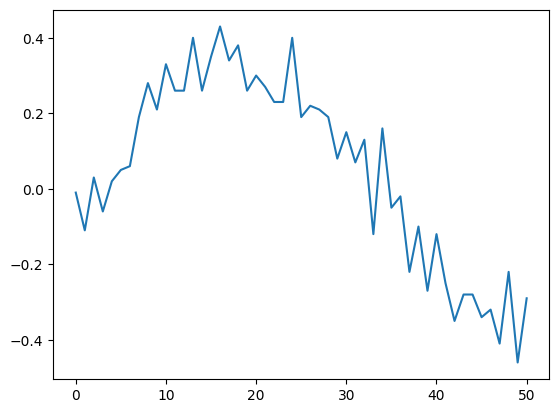

In [3]:
'''
adj = generate_erdos_renyi_sparse_adjacency_matrix(num_nodes=100, edge_prob=0.2)

network = ising_efficient.BeliefNetwork(
    sparse_adj=adj_mat,
    external_field=lambda t, node_idx: jnp.sin(t * 0.1),
    init_state=random_init,
    µ=0.9,
    beta=0.5,
)

result = network.run_for_steps(200)

network.all_states #for each timestep, holds a list of numbers in [-1, 0, 1] with the corresponding state for that node at that time
'''

adj_mat = network_generation.generate_erdos_renyi_sparse_adjacency_matrix(
    num_nodes=100, edge_prob=0.1
)

random_init = jax.random.randint(
    shape=(len(adj_mat),),
    minval=-1,
    maxval=2,
    key=jax.random.PRNGKey(np.random.randint(low=0, high=100)),
)
ones_init = jnp.ones(shape=(len(adj_mat),)).astype(int)

network = ising_efficient.BeliefNetwork(
    sparse_adj=adj_mat,
    external_field=lambda t, node_idx: jnp.sin(t * 0.1),
    init_state=random_init,
    µ=0.9,
    beta=0.5,
)


result = network.run_for_steps(50)
magnetization = np.mean(result, axis=1)
plt.plot(magnetization)
plt.show()

In [4]:
'''
#test 1
test_array = np.array([-1,-1,-1,-1])

test_adj = np.array([
    [1, 1, 0, 0], 
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
])

# test with test_array and test_adj
test_sparse_adj = Sparse_Adjacency_Matrix(test_adj)
test_diameters = belief_state_diameters_over_time(
    sparse_adj=test_sparse_adj,
    all_states=[test_array]
)
print("1. Test diameters:", test_diameters)

#test 2 - separated components
test2_adj = np.array([
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 1, 1]
])

test2_array= np.array([-1, -1, -1, -1])
# test with test_array and test_adj
test2_sparse_adj = Sparse_Adjacency_Matrix(test2_adj)
test2_diameters = belief_state_diameters_over_time(
    sparse_adj=test2_sparse_adj,
    all_states=[test2_array]
)
print("1. Test diameters:", test2_diameters)

'''

'\n#test 1\ntest_array = np.array([-1,-1,-1,-1])\n\ntest_adj = np.array([\n    [1, 1, 0, 0], \n    [1, 1, 1, 0],\n    [0, 1, 1, 1],\n    [0, 0, 1, 1]\n])\n\n# test with test_array and test_adj\ntest_sparse_adj = Sparse_Adjacency_Matrix(test_adj)\ntest_diameters = belief_state_diameters_over_time(\n    sparse_adj=test_sparse_adj,\n    all_states=[test_array]\n)\nprint("1. Test diameters:", test_diameters)\n\n#test 2 - separated components\ntest2_adj = np.array([\n    [1, 1, 0, 0],\n    [1, 1, 0, 0],\n    [0, 0, 1, 1],\n    [0, 0, 1, 1]\n])\n\ntest2_array= np.array([-1, -1, -1, -1])\n# test with test_array and test_adj\ntest2_sparse_adj = Sparse_Adjacency_Matrix(test2_adj)\ntest2_diameters = belief_state_diameters_over_time(\n    sparse_adj=test2_sparse_adj,\n    all_states=[test2_array]\n)\nprint("1. Test diameters:", test2_diameters)\n\n'

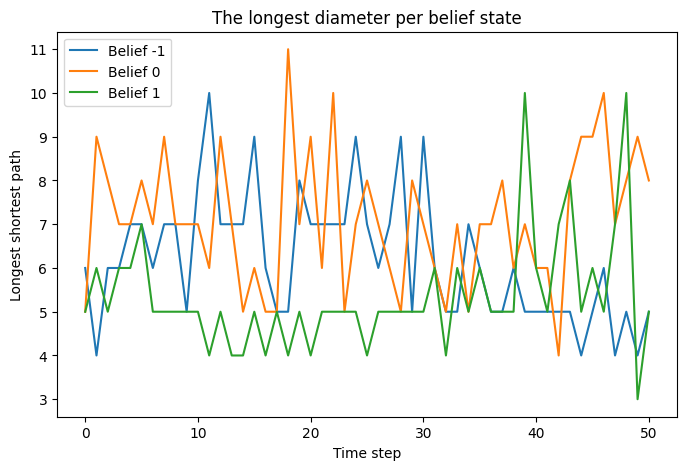

In [5]:
all_states = [np.array(state) for state in result]

diameters = belief_state_diameters_over_time(
    sparse_adj=adj_mat,
    all_states=all_states
)

plt.figure(figsize=(8, 5))
for belief, values in diameters.items():
    plt.plot(values, label=f"Belief {belief}")

plt.xlabel("Time step")
plt.ylabel("Longest shortest path")
plt.title("The longest diameter per belief state")
plt.legend()
plt.show()


# Network topology

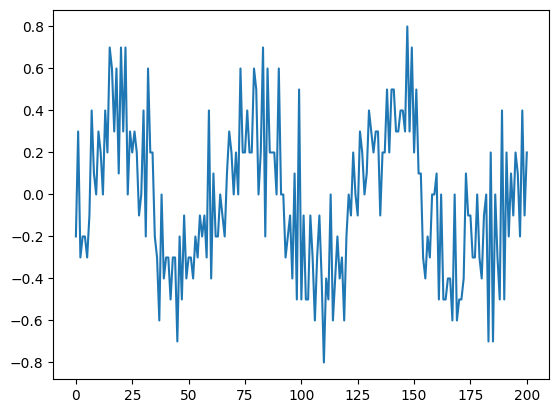

In [6]:
adj_mat = network_generation.generate_erdos_renyi_sparse_adjacency_matrix(
    num_nodes=10, edge_prob=0.1
)

random_init = jax.random.randint(
    shape=(len(adj_mat),),
    minval=-1,
    maxval=2,
    key=jax.random.PRNGKey(np.random.randint(low=0, high=100)),
)
ones_init = jnp.ones(shape=(len(adj_mat),)).astype(int)

network = ising_efficient.BeliefNetwork(
    sparse_adj=adj_mat,
    external_field=lambda t, node_idx: jnp.sin(t * 0.1),
    init_state=random_init,
    µ=0.9,
    beta=0.5,
)

result = network.run_for_steps(200)
magnetization = np.mean(result, axis=1)
plt.plot(magnetization)
plt.show()

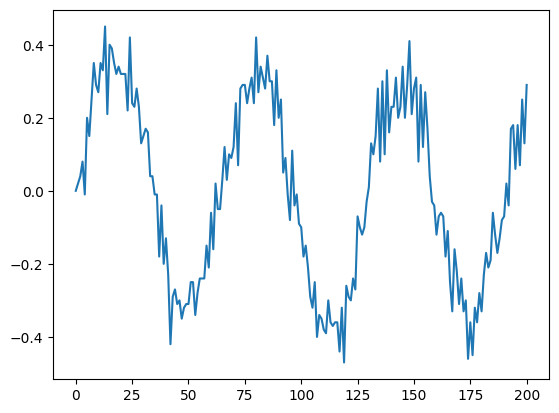

In [7]:
adj_mat = network_generation.generate_scale_free_sparse_adjacency_matrix_jax(
    num_nodes=100, num_edge=5
)

random_init = jax.random.randint(
    shape=(len(adj_mat),),
    minval=-1,
    maxval=2,
    key=jax.random.PRNGKey(np.random.randint(low=0, high=100)),
)
ones_init = jnp.ones(shape=(len(adj_mat),)).astype(int)

network = ising_efficient.BeliefNetwork(
    sparse_adj=adj_mat,
    external_field=lambda t, node_idx: jnp.sin(t * 0.1),
    init_state=random_init,
    µ=0.9,
    beta=0.5,
)

result = network.run_for_steps(200)
magnetization = np.mean(result, axis=1)
plt.plot(magnetization)
plt.show()

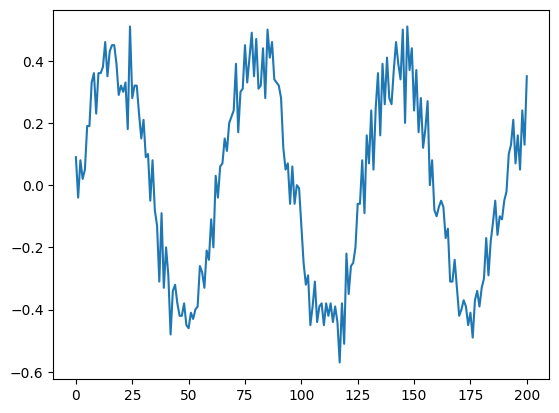

In [8]:
adj_mat = network_generation.generate_small_world_sparse_adjacency_matrix_jax(
    num_nodes=100, k=4, p=0.1
)

random_init = jax.random.randint(
    shape=(len(adj_mat),),
    minval=-1,
    maxval=2,
    key=jax.random.PRNGKey(np.random.randint(low=0, high=100)),
)
ones_init = jnp.ones(shape=(len(adj_mat),)).astype(int)

network = ising_efficient.BeliefNetwork(
    sparse_adj=adj_mat,
    external_field=lambda t, node_idx: jnp.sin(t * 0.1),
    init_state=random_init,
    µ=0.9,
    beta=0.5,
)

result = network.run_for_steps(200)
magnetization = np.mean(result, axis=1)
plt.plot(magnetization)
plt.show()